In [11]:
%pip install tensorflow==2.16.1 keras pandas nltk transformers datasets matplotlib seaborn scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 44.2 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

train = pd.read_parquet("go_emotions_train.parquet")
test = pd.read_parquet("go_emotions_test.parquet")

In [3]:
emotions = train.columns[1:].values
emotions

array(['admiration', 'amusement', 'anger', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
       'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise',
       'neutral'], dtype=object)

<Axes: title={'center': 'Text length distribution'}, ylabel='Frequency'>

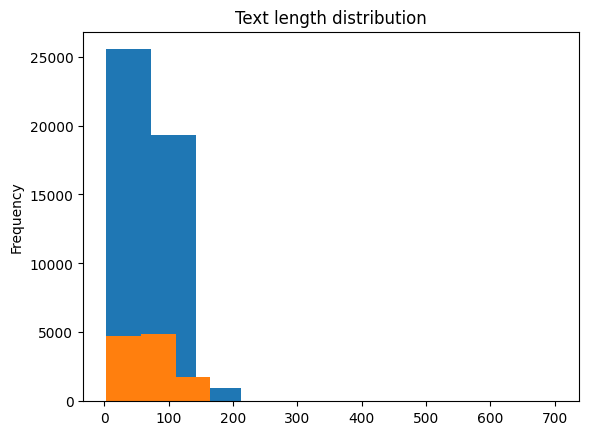

In [4]:
import matplotlib
train["length_text"] = train["text"].apply(len)
train['length_text'].plot(kind='hist', title='Text length distribution')

test["length_text"] = test["text"].apply(len)
test['length_text'].plot(kind='hist', title='Text length distribution')

In [5]:
max_sequence_length = 256

In [6]:
# remove rows with text length > max_sequence_length   
train = train[train["length_text"] <= max_sequence_length]
test = test[test["length_text"] <= max_sequence_length]


<Axes: title={'center': 'Text length distribution'}, ylabel='Frequency'>

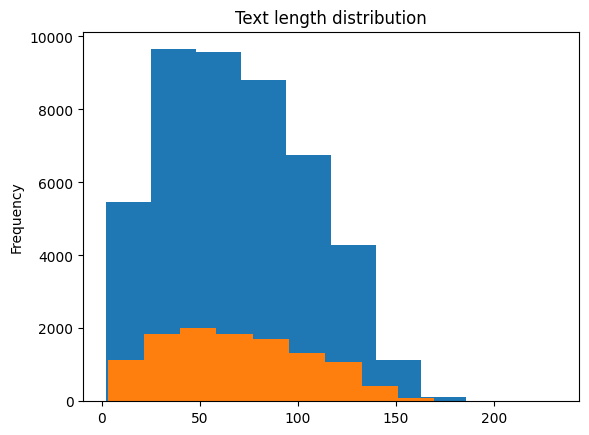

In [7]:
import matplotlib
train["length_text"] = train["text"].apply(len)
train['length_text'].plot(kind='hist', title='Text length distribution')

test["length_text"] = test["text"].apply(len)
test['length_text'].plot(kind='hist', title='Text length distribution')

In [8]:
additional_tokens = [ 
    # smileys
    ":)", ";)", ":P", ":D", ":(", ":'(", ":O", ":/", ":|", ":*", ":@", ">:(", 
    # emojis and their unicode representation
    ":thumbsup:", "👍", ":thumbsdown:", "👎", ":clap:", "👏", ":wave:", "👋", ":pray:", "🙏", 
    ":smile:", "😄", ":grinning:", "😀", ":laughing:", "😆", ":sweat_smile:", "😅", ":rofl:", "🤣", 
    ":blush:", "😊", ":innocent:", "😇", ":wink:", "😉", ":relieved:", "😌", ":heart_eyes:", "😍", 
    ":kissing_heart:", "😘", ":kissing:", "😗", ":kissing_smiling_eyes:", "😙", ":kissing_closed_eyes:", "😚", 
    ":yum:", "😋", ":stuck_out_tongue:", "😛", ":stuck_out_tongue_winking_eye:", "😜", 
    ":stuck_out_tongue_closed_eyes:", "😝", ":money_mouth_face:", "🤑", ":hugs:", "🤗", ":smirk:", "😏", 
    ":unamused:", "😒", ":disappointed:", "😞", ":pensive:", "😔", ":worried:", "😟", ":confused:", "😕", 
    ":persevere:", "😣", ":confounded:", "😖", ":tired_face:", "😫", ":weary:", "😩", ":cry:", "😢", 
    ":sob:", "😭", ":frowning:", "☹️", ":anguished:", "😧", ":fearful:", "😨", ":cold_sweat:", "😰", 
    ":disappointed_relieved:", "😥", ":sweat:", "😓", ":hugging_face:", "🤗", ":thinking:", "🤔", 
    ":shushing_face:", "🤫", ":lying_face:", "🤥", ":no_mouth:", "😶", ":neutral_face:", "😐", 
    ":expressionless:", "😑", ":grimacing:", "😬", ":rolling_eyes:", "🙄", ":hushed:", "😯", 
    ":frowning2:", "☹️", ":anguished:", "😧", ":open_mouth:", "😮", ":astonished:", "😲", 
    ":sleeping:", "😴", ":drooling_face:", "🤤", ":sleepy:", "😪", ":dizzy_face:", "😵", 
    ":zipper_mouth_face:", "🤐", ":nauseated_face:", "🤢", ":sneezing_face:", "🤧", ":mask:", "😷", 
    ":thermometer_face:", "🤒", ":head_bandage:", "🤕", ":smiling_imp:", "😈", ":imp:", "👿", 
    ":japanese_ogre:", "👹", ":japanese_goblin:", "👺", ":skull:", "💀", ":ghost:", "👻", ":alien:", "👽", 
    ":robot:", "🤖", ":poop:", "💩", ":smiley_cat:", "😺", ":smile_cat:", "😸", ":joy_cat:", "😹", 
    ":heart_eyes_cat:", "😻", ":smirk_cat:", "😼", ":kissing_cat:", "😽", ":scream_cat:", "🙀", 
    ":crying_cat_face:", "😿", ":pouting_cat:", "😾", ":raised_hands:", "🙌", ":clap:", "👏", 
    ":wave:", "👋", 
    ]

In [9]:
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


# Tokenize the text data
from transformers import BertTokenizerFast

# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Add additional tokens to the tokenizer
tokenizer.add_tokens(additional_tokens)

max_sequence_length = 200

train_sequences = tokenizer(train['text'].tolist(), 
    padding='max_length', truncation=True, 
    max_length=max_sequence_length, return_tensors='np', 
    return_token_type_ids=False, 
    return_attention_mask=False)
train_labels = train[emotions].values
print(len(train_sequences['input_ids']))

test_sequences = tokenizer(test['text'].tolist(),
    padding='max_length', truncation=True, 
    max_length=max_sequence_length, return_tensors='np', 
    return_token_type_ids=False, 
    return_attention_mask=False)
test_labels = test[emotions].values
print(len(test_sequences['input_ids']))

2024-06-15 12:35:04.763898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/sebdg/anaconda3/envs/tf2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


45792
11448


In [10]:
X_train = train_sequences['input_ids']
y_train = train_labels.astype(np.uint8)
X_test = test_sequences['input_ids']
y_test = test_labels.astype(np.uint8)


print(type(X_train[0]), type(y_train[0]))
print(type(X_train[0][0]), type(y_train[0][0]))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.int64'> <class 'numpy.uint8'>
(45792, 200) (45792, 28)
(11448, 200) (11448, 28)


In [22]:
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

# Define the learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [12]:
import tensorflow as tf ; print("Num GPUs Available: ", tf.config.experimental.list_physical_devices("GPU"))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2024-06-15 12:35:24.584102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 12:35:24.584429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 12:35:24.827635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 12:35:24.827759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 12:35:24.827858: I external/local_xla/xla/stream_executor

In [36]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional, Reshape

embedding_dim = 256  # Embedding dimension
max_sequence_length = 256  # Example sequence length, adjust as needed
tokenizer_vocab_size = tokenizer.vocab_size  # Example vocabulary size, adjust as needed

# Number of classes for multi-label classification
num_classes = 28  # Adjust based on your dataset

# Define the CNN model architecture
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=tokenizer_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),  # Embedding layer
    Conv1D(filters=128, kernel_size=32, activation='relu'),  # Conv1D layer
    Dropout(0.2),  # Dropout for regularization
    Dense(2048, activation='relu'),  # Dense layer
    Dense(1512, activation='relu'),  # Dense layer
    Dense(1024, activation='relu'),  # Dense layer
    Conv1D(filters=128, kernel_size=16, activation='relu'),  # Conv1D layer
    Dropout(0.2),  # Dropout for regularization
    Dense(256, activation='relu'),  # Dense layer
    Dense(128, activation='relu'),  # Dense layer
    Conv1D(filters=96, kernel_size=8, activation='relu'),  # Conv1D layer
    Dropout(0.2),  # Dropout for regularization
    Dense(128, activation='relu'),  # Dense layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Conv1D layer
    Conv1D(filters=64, kernel_size=8, activation='relu'),  # Conv1D layer
    GlobalMaxPooling1D(),  # Global max pooling
    Dropout(0.2),  # Dropout for regularization
    Dense(128, activation='relu'),  # Dense layer
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Dense layer
    Dropout(0.2),  # Dropout for regularization
    Dense(num_classes, activation='sigmoid')  # Output layer for multi-label classification
])
# Compile the model with a lower learning rate
initial_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='binary_crossentropy',  # Binary cross-entropy loss for multi-label classification
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 256, 256)       │     7,813,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 225, 128)       │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 225, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 225, 2048)      │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 225, 1512)      │     3,098,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 225, 1024)      │     1,549,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 210, 128)       │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 210, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 210, 256)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 210, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 203, 96)        │        98,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 203, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 203, 128)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 199, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 192, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,140,196 (61.57 MB)

 Trainable params: 16,140,196 (61.57 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LayerNormalization, Embedding, MultiHeadAttention, GlobalAveragePooling1D
from keras.optimizers import Adam

embedding_dim = 128  # Embedding dimension
max_sequence_length = 256  # Example sequence length, adjust as needed
tokenizer_vocab_size = tokenizer.vocab_size  # Example vocabulary size, adjust as needed
num_classes = 28  # Adjust based on your dataset

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model():
    inputs = Input(shape=(200,))
    embedding_layer = Embedding(input_dim=tokenizer_vocab_size, output_dim=embedding_dim, input_length=200)(inputs)
    x = transformer_encoder(embedding_layer, head_size=512, num_heads=2, ff_dim=384, dropout=0.3)
    x = transformer_encoder(x, head_size=512, num_heads=2, ff_dim=384, dropout=0.3)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(768, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(384, activation='relu')(x)
    x = Dense(384, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
model = build_transformer_model()

# Summary of the model
model.summary()


/home/sebdg/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-06-15 12:35:55.663332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 12:35:55.663537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 12:35:55.663601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 12:35:55.663653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file t

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  3,906,816 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 128)  │        256 │ embedding[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 128)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200, 384)  │     49,536 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 384)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 128)  │     49,280 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 128)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 200, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 128)  │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200, 384)  │     49,536 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 200, 384)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 200, 128)  │     49,280 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,959,836 (26.55 MB)

 Trainable params: 6,959,836 (26.55 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
print(model.predict(X_train[:1]),  y_train[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.5300808  0.22104229 0.0086417  0.07409772 0.2905094  0.05017401
  0.14316636 0.19374387 0.03933959 0.03424186 0.02259022 0.00940622
  0.03993716 0.12829407 0.00807774 0.02331676 0.00512263 0.05890626
  0.02570435 0.00739943 0.10223275 0.00642745 0.10901143 0.01400776
  0.00628876 0.00698923 0.438469   0.24379589]] [[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.1793 - loss: 0.2262 - val_accuracy: 0.1990 - val_loss: 0.3225 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.1831 - loss: 0.2259 - val_accuracy: 0.1957 - val_loss: 0.3211 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.1799 - loss: 0.2242 - val_accuracy: 0.1975 - val_loss: 0.3294 - learning_rate: 1.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.1868 - loss: 0.2221 - val_accuracy: 0.2027 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.1889 - loss: 0.2213 - val_accuracy: 0.2016 - val_loss: 0.3499 - learning_rate: 1.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - accuracy: 0.1900 - loss: 0.2199 - val_accuracy: 0.2011 - val_loss: 0.3477 - learning_rate: 1.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 425ms/step - acc

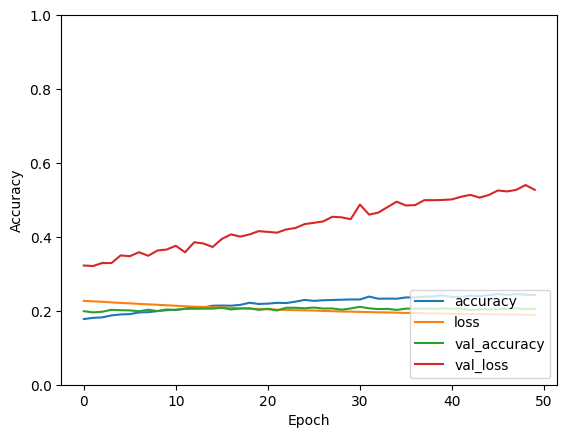

In [29]:
from matplotlib import pyplot as plt    
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-4, decay_factor=0.1, step_size=3):
    '''
    Wrapper function to create a step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))

    return LearningRateScheduler(schedule)
initial_lr = 1e-4
lr_scheduler = step_decay_schedule(initial_lr=initial_lr, decay_factor=0.75, step_size=10)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=2048, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


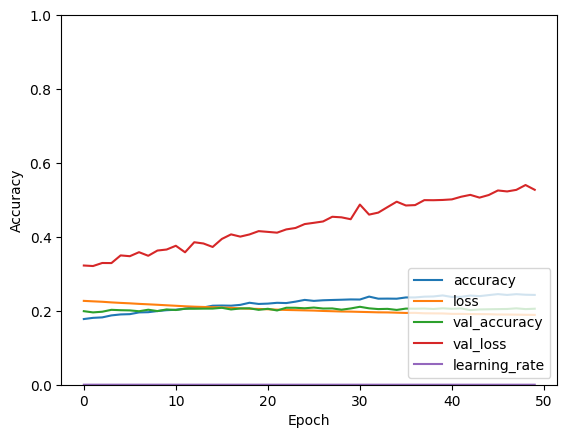

In [30]:

# plot the history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['learning_rate'], label = 'learning_rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

